In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '/global/homes/e/ecastori/PostBorn/'

In [3]:
data = np.loadtxt(path+'FFT_k-1Pk.dat',skiprows=2)

#----------------------#
n         = data[:,0]
Re_c_n    = data[:,1]
Im_c_n    = data[:,2]
Re_nu_n   = data[:,3]
Im_nu_n   = data[:,4]
#----------------------#

c_n  = Re_c_n  + 1j * Im_c_n
nu_n = Re_nu_n + 1j * Im_nu_n

In [4]:
data = np.loadtxt(path+'Il_nu_t.dat',skiprows=1)

#----------------------#
ell       = data[:,0]
nn        = data[:,2]
tt        = data[:,1]
Re_I      = data[:,3]
Im_I      = data[:,4]
#----------------------#

I_ = Re_I + 1j * Im_I

In [5]:
#cosmology
h         = 0.6770
omega_cdm = 0.11923
omega_b   = 0.02247
Omega_b   = omega_b/h**2
Omega_cdm = omega_cdm/h**2
Omega_m   = Omega_b+Omega_cdm
ns        = 0.96824
A0        = 2.10732*10**(-9)

#dictionary for class
cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
print(cosmo_dict)

# speed of light
c      = 299792458./1000. # km/s

#prefactor for Cl_kk computation from Cl_dd
prefac = 1.5*Omega_m*(100.)**2/c**2 #without h

{'h': 0.677, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'A_s': 2.10732e-09, 'n_s': 0.96824, 'k_pivot': 0.05}


In [14]:
from classy import Class
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
cosmo_b               = cosmo.get_background()

class_z               = cosmo_b['z'][::-1]
class_chi             = cosmo_b['comov. dist.'][::-1]
class_D               = cosmo_b['gr.fac. D'][::-1]#/cosmo_b['gr.fac. D'][-1]

derivParams           = cosmo.get_current_derived_parameters(['z_rec'])
z_cmb                 = derivParams['z_rec']


from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline as ius
chi_z = interp1d(class_z,class_chi*h)
z_chi = interp1d(class_chi*h,class_z)  # Mpc/h
D_chi = interp1d(class_chi*h,class_D)    # growth
D_z   = interp1d(class_z,class_D)
# chi_cmb
chi_cmb = chi_z(z_cmb)




0.0

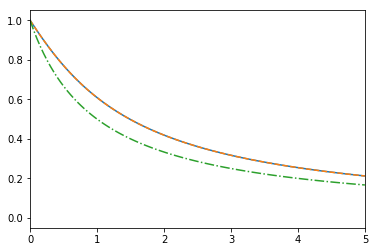

array(1.)

In [7]:
z = np.linspace(0,5,100)
plt.figure()
plt.plot(class_z,class_D,ls='-')
plt.plot(z,D_z(z),ls='--')
plt.plot(z,1/(1+z),ls='-.')
plt.xlim(0,5)
plt.show()
D_z(0)

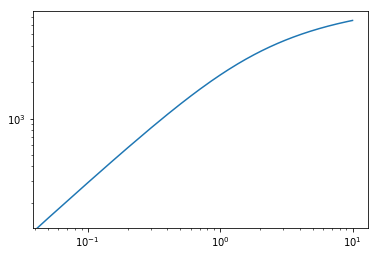

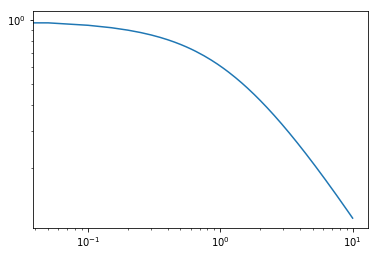

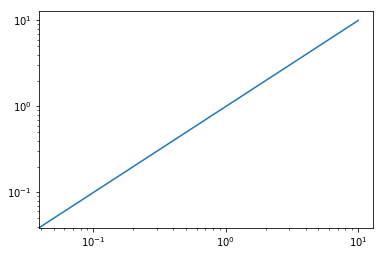

In [8]:
z=np.linspace(0.,10,200)
plt.figure()
plt.loglog(z,chi_z(z))
plt.show()
plt.figure()
plt.loglog(z,D_chi(chi_z(z)))
plt.show()
plt.figure()
plt.loglog(z,z_chi(chi_z(z)))
plt.show()

In [9]:
D_chi(chi_z(0.1))

array(0.94886829)

In [10]:
4./np.pi

1.2732395447351628

In [11]:
def set_kernel(chi_max):
    def kernel(chi):
        return (1.+z_chi(chi))*D_chi(chi)
    return kernel

In [12]:
W = set_kernel(chi_cmb)

In [13]:
ell_ = np.unique(ell)
nu_n_= np.unique(nu_n) 
print(nu_n_)
print(ell_)
print(np.unique(tt))
t_=np.unique(tt)
print(len(nu_n_),len(n),len(c_n),len(t_))
print(len(tt),len(I_))

[-1.9-27.9447j   -1.9-27.6653j   -1.9-27.3858j   -1.9-27.1064j
 -1.9-26.8269j   -1.9-26.5475j   -1.9-26.268j    -1.9-25.9886j
 -1.9-25.7091j   -1.9-25.4297j   -1.9-25.1502j   -1.9-24.8708j
 -1.9-24.5913j   -1.9-24.3119j   -1.9-24.0325j   -1.9-23.753j
 -1.9-23.4736j   -1.9-23.1941j   -1.9-22.9147j   -1.9-22.6352j
 -1.9-22.3558j   -1.9-22.0763j   -1.9-21.7969j   -1.9-21.5174j
 -1.9-21.238j    -1.9-20.9585j   -1.9-20.6791j   -1.9-20.3996j
 -1.9-20.1202j   -1.9-19.8407j   -1.9-19.5613j   -1.9-19.2818j
 -1.9-19.0024j   -1.9-18.723j    -1.9-18.4435j   -1.9-18.1641j
 -1.9-17.8846j   -1.9-17.6052j   -1.9-17.3257j   -1.9-17.0463j
 -1.9-16.7668j   -1.9-16.4874j   -1.9-16.2079j   -1.9-15.9285j
 -1.9-15.649j    -1.9-15.3696j   -1.9-15.0901j   -1.9-14.8107j
 -1.9-14.5312j   -1.9-14.2518j   -1.9-13.9724j   -1.9-13.6929j
 -1.9-13.4135j   -1.9-13.134j    -1.9-12.8546j   -1.9-12.5751j
 -1.9-12.2957j   -1.9-12.0162j   -1.9-11.7368j   -1.9-11.4573j
 -1.9-11.1779j   -1.9-10.8984j   -1.9-10.619j    -1.9-10

In [14]:
nu=nu_n_

res=[]
m = 0
for ii,ll in enumerate(ell_):
    print(ii,ll)
    for t in t_:
        for r in t_:
            res+=[np.real(sum(I_[m:m+len(n)][0:-1]*c_n[0:-1]*2.*(chi_cmb*r)**(-nu[0:-1]))+I_[m:m+len(n)][-1]*c_n[-1]*(chi_cmb*r)**(-nu[-1]))]
        m+=len(n)
assert(m==len(I_))



0 2.0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


1 3.0
2 4.0
3 5.0
4 6.0
5 7.0
6 8.0
7 9.0
8 10.0
9 11.0
10 12.0
11 13.0
12 14.0
13 15.0
14 16.0
15 17.0
16 18.0
17 19.0
18 20.0
19 21.0
20 22.0
21 23.0
22 24.0
23 25.0
24 26.0
25 27.0
26 28.0
27 29.0
28 30.0
29 31.0
30 32.0
31 33.0
32 34.0
33 35.0
34 36.0
35 37.0
36 38.0
37 39.0
38 40.0
39 41.0
40 42.0
41 43.0
42 44.0
43 45.0
44 46.0
45 47.0
46 48.0
47 49.0
48 50.0
49 51.0
50 52.0
51 53.0
52 54.0
53 55.0
54 56.0
55 57.0
56 58.0
57 59.0
58 60.0
59 61.0
60 62.0
61 63.0
62 64.0
63 65.0
64 66.0
65 67.0
66 68.0
67 69.0
68 70.0
69 71.0
70 72.0
71 73.0
72 74.0
73 75.0
74 76.0
75 77.0
76 78.0
77 79.0
78 80.0
79 81.0
80 82.0
81 83.0
82 84.0
83 85.0
84 86.0
85 87.0
86 88.0
87 89.0
88 90.0
89 91.0
90 92.0
91 93.0
92 94.0
93 95.0
94 96.0
95 97.0
96 98.0
97 99.0
98 100.0
99 110.0
100 120.0
101 130.0
102 140.0
103 150.0
104 160.0
105 170.0
106 180.0
107 190.0
108 200.0
109 210.0
110 220.0
111 230.0
112 240.0
113 250.0
114 260.0
115 270.0
116 280.0
117 290.0
118 300.0
119 310.0
120 320.0
121 330.0
12

In [15]:
m

2948089

In [16]:
res=np.asarray(res)

In [17]:
(chi_cmb*r)**(-nu[-1])

(35499593.43314305+0j)

In [18]:
np.real(c_n)

array([ 2.71704e-02,  4.39959e-02,  2.97611e-02,  1.25405e-02,
       -6.59950e-03, -2.63014e-02, -4.48783e-02, -6.04709e-02,
       -7.12008e-02, -7.52529e-02, -7.11193e-02, -5.80787e-02,
       -3.65778e-02, -8.16360e-03,  2.47916e-02,  5.89685e-02,
        8.97352e-02,  1.11465e-01,  1.18834e-01,  1.08242e-01,
        7.86659e-02,  3.21836e-02, -2.55783e-02, -8.55578e-02,
       -1.36503e-01, -1.67182e-01, -1.68866e-01, -1.37527e-01,
       -7.55254e-02,  7.62463e-03,  9.62004e-02,  1.71228e-01,
        2.14648e-01,  2.13501e-01,  1.63488e-01,  7.13340e-02,
       -4.52332e-02, -1.60520e-01, -2.46228e-01, -2.77942e-01,
       -2.41678e-01, -1.39081e-01,  1.05691e-02,  1.72815e-01,
        3.04971e-01,  3.66438e-01,  3.30463e-01,  1.94548e-01,
       -1.41040e-02, -2.41476e-01, -4.19079e-01, -4.83575e-01,
       -3.98805e-01, -1.73377e-01,  1.33788e-01,  4.25338e-01,
        5.94501e-01,  5.63734e-01,  3.19920e-01, -6.89663e-02,
       -4.67212e-01, -7.15947e-01, -6.96001e-01, -3.849

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


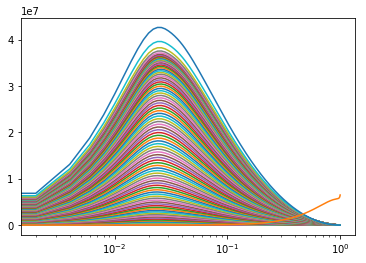

In [32]:
from scipy.integrate import simps, quadrature
from scipy.interpolate import interp1d
m=0
result=[]
for ii,ll in enumerate(ell_):
    res_=[]
    for t in t_:
        
        #for r in t_:
        integrand=W(t*t_*chi_cmb)*W(t*chi_cmb)*(1.-t_*t)/t*(1.-t_)/t_*res[m:m+len(t_)]

            
        m+=len(t_)
        integrand[0] = 0.#+1j*0.

        integrand = interp1d(t_,integrand,kind='cubic')
        t_long  = np.linspace(min(t_),max(t_),500)
        if ll==3:
            plt.semilogx(t_long,integrand(t_long))
        res_+=[simps(integrand(t_long),t_long)]#quadrature(integrand,min(t_),max(t_))[0]]
    #print(res_)
        # for every n do r integral
    integrand = np.asarray(res_)

    
    integrand[0] = 0.#+1j*0.
    integrand = interp1d(t_,integrand,kind='cubic')
    result+=[simps(integrand(t_long),t_long)]#min(t_),max(t_))[0]]
    


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


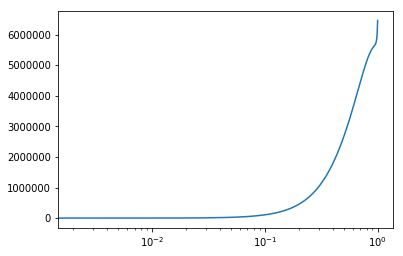

In [76]:
from scipy.integrate import simps, quadrature
from scipy.interpolate import interp1d
m=0
result=[]
for ii,ll in enumerate(ell_):
    res_=[]
    for t in t_:
        
        #for r in t_:
        integrand=W(t*t_*chi_cmb)*(1.-t_*t)*(1.-t_)/t_*res[m:m+len(t_)]

            
        m+=len(t_)
        integrand[0] = 0.#+1j*0.
        #if ll==20:
        #    plt.semilogx(t_,integrand)
        integrand = interp1d(t_,integrand,kind='linear')
        t_long = np.linspace(min(t_),max(t_),500)
        res_+=[simps(integrand(t_long),t_long)]#quadrature(integrand,min(t_),max(t_))[0]]
    #print(res_)
        # for every n do r integral
    integrand = np.asarray(res_)*W(t_*chi_cmb)/t_

    
    integrand[0] = 0.#+1j*0.
    integrand = interp1d(t_,integrand,kind='linear')
    if ll==3:
        plt.semilogx(t_long,integrand(t_long))
    result+=[simps(integrand(t_long),t_long)]#min(t_),max(t_))[0]]
        

In [67]:
Cl=np.real(np.asarray(result))*4./np.pi**2*prefac**2
print(Cl)

[9.83092807e-09 2.99714964e-09 1.24448517e-09 6.16181082e-10
 3.42107515e-10 2.06122677e-10 1.32091296e-10 8.87925068e-11
 6.19863526e-11 4.46228916e-11 3.29565992e-11 2.48775959e-11
 1.91354279e-11 1.49611486e-11 1.18661764e-11 9.53160339e-12
 7.74339950e-12 6.35459080e-12 5.26231653e-12 4.39343248e-12
 3.69519010e-12 3.12898104e-12 2.66608408e-12 2.28484345e-12
 1.96868574e-12 1.70482711e-12 1.48328126e-12 1.29619561e-12
 1.13734559e-12 1.00176733e-12 8.85484817e-13 7.85285641e-13
 6.98583104e-13 6.23268225e-13 5.57609741e-13 5.00172902e-13
 4.49784986e-13 4.05452054e-13 3.66326293e-13 3.31714300e-13
 3.00998371e-13 2.73678239e-13 2.49318062e-13 2.27538901e-13
 2.08027123e-13 1.90503431e-13 1.74735335e-13 1.60518572e-13
 1.47672081e-13 1.36045845e-13 1.25506223e-13 1.15931304e-13
 1.07224409e-13 9.92930991e-14 9.20551491e-14 8.54448291e-14
 7.93962681e-14 7.38561727e-14 6.87756302e-14 6.41096051e-14
 5.98184947e-14 5.58682759e-14 5.22274895e-14 4.88679610e-14
 4.57632324e-14 4.289210

(2, 500)

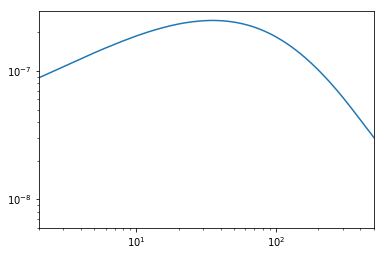

In [68]:
plt.figure()
plt.loglog(ell_,1/4.*(ell_*(ell_+1.))**2*Cl)
plt.xlim(2,500)

In [69]:
cosmo = Class()

cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
cosmo_dict['output']='lCl, tCl'
cosmo_dict['l_max_scalars']=2000
cosmo_dict['lensing']='yes'
cosmo_dict['l_switch_limber']=100
cosmo_dict['perturb_sampling_stepsize']=0.01

cosmo.set(cosmo_dict)
cosmo.compute()
cllen= cosmo.lensed_cl(lmax=1000)
ll = cllen['ell']
clpp = cllen['pp']

In [70]:
data=np.loadtxt(path+'Cell_marko.dat')
cl = data[:,1]

ls = data[:,0]


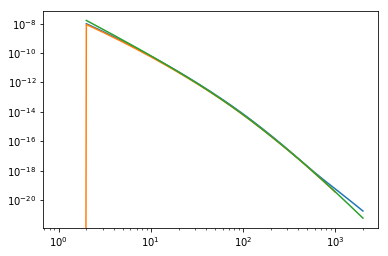

In [71]:
plt.figure()
plt.loglog(ell_,Cl)
plt.loglog(ll,clpp)
plt.loglog(ls,cl)

In [72]:
Cl

array([9.83092807e-09, 2.99714964e-09, 1.24448517e-09, 6.16181082e-10,
       3.42107515e-10, 2.06122677e-10, 1.32091296e-10, 8.87925068e-11,
       6.19863526e-11, 4.46228916e-11, 3.29565992e-11, 2.48775959e-11,
       1.91354279e-11, 1.49611486e-11, 1.18661764e-11, 9.53160339e-12,
       7.74339950e-12, 6.35459080e-12, 5.26231653e-12, 4.39343248e-12,
       3.69519010e-12, 3.12898104e-12, 2.66608408e-12, 2.28484345e-12,
       1.96868574e-12, 1.70482711e-12, 1.48328126e-12, 1.29619561e-12,
       1.13734559e-12, 1.00176733e-12, 8.85484817e-13, 7.85285641e-13,
       6.98583104e-13, 6.23268225e-13, 5.57609741e-13, 5.00172902e-13,
       4.49784986e-13, 4.05452054e-13, 3.66326293e-13, 3.31714300e-13,
       3.00998371e-13, 2.73678239e-13, 2.49318062e-13, 2.27538901e-13,
       2.08027123e-13, 1.90503431e-13, 1.74735335e-13, 1.60518572e-13,
       1.47672081e-13, 1.36045845e-13, 1.25506223e-13, 1.15931304e-13,
       1.07224409e-13, 9.92930991e-14, 9.20551491e-14, 8.54448291e-14,
      

In [23]:
cosmo = Class()

cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
cosmo_dict['output']='lCl, tCl, mPk'
cosmo_dict['l_max_scalars']=2000
cosmo_dict['lensing']='yes'
cosmo_dict['l_switch_limber']=1

cosmo.set(cosmo_dict)
cosmo.compute()
cllen= cosmo.lensed_cl(lmax=1000)
ll2 = cllen['ell']
clpp2 = cllen['pp']

cosmo.sigma8()

0.8221362793660904

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


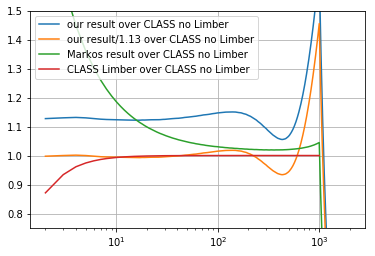

In [74]:
plt.figure()#
plt.semilogx(ell_,Cl/np.interp(ell_,ll,clpp), label='our result over CLASS no Limber')
plt.semilogx(ell_,Cl/np.interp(ell_,ll,clpp)/1.13, label='our result/1.13 over CLASS no Limber')
#plt.semilogx(ell_,np.interp(ell_,ls,cl)/Cl)
plt.semilogx(ls,cl/np.interp(ls,ll,clpp), label='Markos result over CLASS no Limber')
plt.semilogx(ll,clpp2/clpp, label='CLASS Limber over CLASS no Limber') 
#plt.axhline(1,color='black')
plt.ylim(0.75,1.5)
plt.grid()
plt.legend()

In [90]:
x = y = z = np.arange(0.0,5.0,1.0)
np.savetxt('test.out', (x,y,z))
type(ll)

numpy.float64

In [92]:
np.savetxt('class_ouput.out',X=(ll2,clpp,clpp2))

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


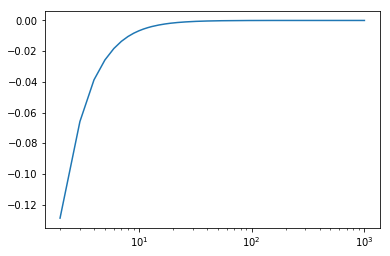

In [75]:
plt.semilogx(ll,clpp2/clpp-1, label='CLASS Limber over CLASS no Limber')